# Iterative Method for Barycenter Computation
**GPU-only implementation.**

In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm, tqdm_notebook

import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output

import os, sys
sys.path.append("..")

import torch
from torch import nn
from torch.nn import functional as F

from scipy.stats import ortho_group
from scipy.linalg import sqrtm

from src.icnn import DenseICNN_U
from src.plotters import plot_training_phase
from src.tools import ewma, score_gen, freeze, unfreeze
from src.fid_score import calculate_frechet_distance
from src import distributions
from src import bar_benchmark
import itertools

import gc
from sklearn.decomposition import PCA

from copy import deepcopy

%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

# Get the parent folder path (folder K)
parent_folder = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

print(parent_folder)

folder_classes_path = os.path.join(parent_folder, 'classes')
sys.path.append(folder_classes_path)

from input_generate_entropy import *
from true_WB import *
from entropic_iterative_scheme import *
from sample_plot import *

/Users/zeyichen/GitHub/Repo/WB_Algo/WIN_Korotin


## Config

In [3]:
dim = 2
assert dim > 1

GPU_DEVICE = 0 # GPU index starting from 0
BATCH_SIZE = 1024

LAMBDA = 10
G_LR = 1e-4
D_LR = 1e-3
MAX_ITER = 10001

D_ITERS = 50
T_ITERS = 10
G_ITERS = 50

PLOT_FREQ = 499
SCORE_FREQ = 499

# Parameters for input distributions
NUM = 5 # we have 5 input measures
ALPHAS = np.array([1. / NUM for _ in range(NUM)])

CASE = {
    'type' : 'EigWarp', 
    'sampler' : 'Rectangles', #'Gaussians', #'SwissRoll',# , #
    'params' : {'num' : NUM, 'alphas' : ALPHAS, 'min_eig' : .5, 'max_eig' : 2}
}


OUTPUT_SEED = 0xBADBEEF

In [4]:
import torch
print(torch.cuda.device_count())
print(torch.cuda.is_available())


0
False


In [ ]:

assert torch.cuda.is_available()
torch.cuda.set_device(GPU_DEVICE)

np.random.seed(OUTPUT_SEED)
torch.manual_seed(OUTPUT_SEED)

## Initializing distributions

In [ ]:
# if CASE['type'] == 'EigWarp':
#     if CASE['sampler'] == 'Gaussians':
#         sampler = distributions.StandardNormalSampler(dim=dim)
#     elif CASE['sampler'] == 'SwissRoll':
#         assert dim == 2
#         sampler = distributions.SwissRollSampler()
#     elif CASE['sampler'] == 'Rectangles':
#         sampler = distributions.CubeUniformSampler(dim=dim, normalized=True, centered=True)
    
#     benchmark = bar_benchmark.EigenWarpBenchmark(sampler, **CASE['params'])

## Discriminators Setup

In [ ]:
D = nn.Sequential(
    nn.Linear(dim, max(100, 2*dim)),
    nn.ReLU(True),
    nn.Linear(max(100, 2*dim), max(100, 2*dim)),
    nn.ReLU(True),
    nn.Linear(max(100, 2*dim), max(100, 2*dim)),
    nn.ReLU(True),
    nn.Linear(max(100, 2*dim), 1)
).cuda() #.cpu()

T = nn.Sequential(
    nn.Linear(dim, max(100, 2*dim)),
    nn.ReLU(True),
    nn.Linear(max(100, 2*dim), max(100, 2*dim)),
    nn.ReLU(True),
    nn.Linear(max(100, 2*dim), max(100, 2*dim)),
    nn.ReLU(True),
    nn.Linear(max(100, 2*dim), dim)
).cuda() #.cpu()

In [6]:
num_measures = 5

In [ ]:
Ds = nn.ModuleList([deepcopy(D) for _ in range(num_measures)]).cuda() #.cpu()
Ts = nn.ModuleList([deepcopy(T) for _ in range(num_measures)]).cuda() #.cpu()

Ds_inv = nn.ModuleList([deepcopy(D) for _ in range(num_measures)]).cuda() #.cpu()
Ts_inv = nn.ModuleList([deepcopy(T) for _ in range(num_measures)]).cuda() #.cpu()

## Generator Setup

In [ ]:
# For now dim_Z = dim_X
# Z_sampler = distributions.StandardNormalSampler(dim=dim, device='cpu')
Z_sampler = distributions.StandardNormalSampler(dim=dim, device='cuda')

In [33]:
G = nn.Sequential(
    nn.Linear(dim, max(100, 2*dim)),
    nn.ReLU(True),
    nn.Dropout(0.005),
    nn.Linear(max(100, 2*dim), max(100, 2*dim)),
    nn.ReLU(True),
    nn.Dropout(0.005),
    nn.Linear(max(100, 2*dim), max(100, 2*dim)),
    nn.ReLU(True),
    nn.Linear(max(100, 2*dim), dim)
).cpu()

In [34]:
G_opt = torch.optim.Adam(G.parameters(), lr=1e-4, weight_decay=1e-8)
loss = np.inf

G.train(True)

for iteration in tqdm_notebook(range(10000)):
    Z = Z_sampler.sample(BATCH_SIZE).detach() * 3
    loss = F.mse_loss(Z, G(Z))
    loss.backward()
    G_opt.step(); G_opt.zero_grad()
    print(loss.item())
    if loss.item() < 1e-2:
        break

print(loss)

  0%|          | 0/10000 [00:00<?, ?it/s]

8.793593406677246
8.85535717010498
8.454925537109375
8.282353401184082
8.142451286315918
8.389778137207031
8.042010307312012
8.227149963378906
7.917454719543457
8.290447235107422
8.211966514587402
8.384703636169434
7.849342346191406
7.79125452041626
7.756069183349609
7.775699615478516
8.084632873535156
8.181655883789062
8.283377647399902
7.905814170837402
7.774835109710693
8.279948234558105
7.319549560546875
7.464200496673584
7.621246337890625
7.543552875518799
7.481691837310791
7.49804162979126
6.8654465675354
7.446059226989746
7.036448001861572
6.755903720855713
6.9947638511657715
7.186295509338379
7.041487216949463
7.275302886962891
6.955502510070801
7.012049198150635
6.802009582519531
6.6736063957214355
6.525954246520996
6.322202682495117
6.392058849334717
6.332045555114746
6.365079402923584
6.339801788330078
6.563875198364258
6.246234893798828
6.299699783325195
6.3682661056518555
5.974085807800293
6.462244987487793
5.903334140777588
5.974859714508057
5.8170576095581055
5.717162132

## PCA

In [11]:
pca = PCA(n_components=2)

class Identity:
    pass

# if benchmark.bar_sampler is not None:
#     pca.fit(benchmark.bar_sampler.sample(100000).cpu().detach().numpy())
# elif benchmark.gauss_bar_sampler is not None:
#     pca.fit(benchmark.gauss_bar_sampler.sample(100000).cpu().detach().numpy())
# else:
#     pca = Identity()
#     pca.transform = lambda x: x
    
# No PCA for dim=2
if dim == 2:
    pca = Identity()
    pca.transform = lambda x: x

## Main training

In [12]:
G_opt = torch.optim.Adam(G.parameters(), lr=G_LR, weight_decay=1e-10)
Ts_opt, Ds_opt = [], []
Ts_inv_opt, Ds_inv_opt = [], []
for k in range(num_measures):
    Ts_opt.append(torch.optim.Adam(Ts[k].parameters(), lr=D_LR, weight_decay=1e-10))
    Ds_opt.append(torch.optim.Adam(Ds[k].parameters(), lr=D_LR, weight_decay=1e-10))
    Ts_inv_opt.append(torch.optim.Adam(Ts_inv[k].parameters(), lr=D_LR, weight_decay=1e-10))
    Ds_inv_opt.append(torch.optim.Adam(Ds_inv[k].parameters(), lr=D_LR, weight_decay=1e-10))

In [13]:
G_loss_history = []

G_UVP_history = []

# if hasattr(benchmark, 'gauss_bar_cost'):
#     print('Gaussian Barycenter Cost:', benchmark.gauss_bar_cost)

In [14]:
it = 0
last_plot_it = -1
last_score_it = -1

In [15]:
dim = 2
# dim = 10
num_samples = 5000
num_measures = 5
iter = 0
truncated_radius = 100
seed = 1009

In [16]:
source_sampler = MixtureOfGaussians(dim)
source_sampler.random_components(num_components=5, uniform_weights = True, seed = seed) # seed from the measure selection
source_sampler.set_truncation(truncated_radius)

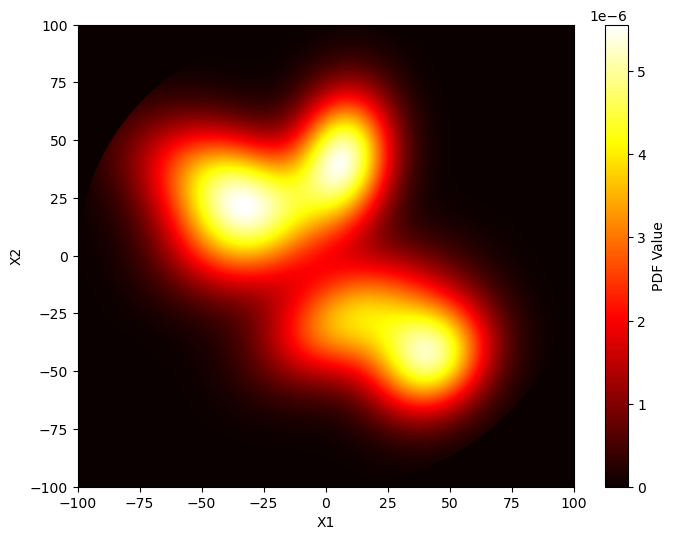

In [17]:
plot_2d_gmm_pdf(source_sampler, truncated_radius, save_path = None)

In [18]:
auxiliary_measure_sampler_set = []
for auxiliary_seed in [1010, 1018, 1014, 1016, 1003]:
    auxiliary_measure_sampler = MixtureOfGaussians(dim)
    auxiliary_measure_sampler.random_components(num_components=5, uniform_weights = True, seed = auxiliary_seed)
    auxiliary_measure_sampler.set_truncation(truncated_radius)
    auxiliary_measure_sampler_set.append(auxiliary_measure_sampler)

In [19]:
# construct entropic_sampler
entropic_sampler = entropic_input_sampler(dim, 
                                          num_measures, 
                                          auxiliary_measure_sampler_set, 
                                          source_sampler = source_sampler, 
                                          n_k = 1000, 
                                          seed = 120, 
                                          gamma = 0.3, 
                                          manual = True,
                                          truncated_radius = truncated_radius,
                                          bound_type = "eigen_bound")

In [20]:
result_dir = f"results/WIN_measures_{num_measures}_seed_{seed}_samples_{num_samples}_dim_{dim}"
os.makedirs(result_dir, exist_ok=True)

In [21]:
import pickle
# Load the sampler attributes from pkl files (only when the entropic_sampler has been set up)
with open(f"{result_dir}/entropic_sampler_info.pkl", "rb") as f:
    loaded_data_entropic_sampler = pickle.load(f)

with open(f"{result_dir}/source_sampler_info.pkl", "rb") as f:
    loaded_data_source_sampler = pickle.load(f)

print("Loaded Data for Entropic Sampler:", loaded_data_entropic_sampler)
print("Loaded Data for Source Sampler:", loaded_data_source_sampler)

Loaded Data for Entropic Sampler: {'dim': 2, 'num_measures': 5, 'auxiliary_measure_sampler_set': [<true_WB.MixtureOfGaussians object at 0x180d953d0>, <true_WB.MixtureOfGaussians object at 0x180e10cd0>, <true_WB.MixtureOfGaussians object at 0x180e11150>, <true_WB.MixtureOfGaussians object at 0x180e115d0>, <true_WB.MixtureOfGaussians object at 0x180e11a50>], 'tilde_K': 5, 'source_sampler': <true_WB.MixtureOfGaussians object at 0x180e11f90>, 'n_k': 1000, 'seed': 120, 'rng_entropy': RandomState(MT19937) at 0x180D00F40, 'gamma': 0.3, 'manual': True, 'truncated_radius': 150, 'bound_type': 'eigen_bound', 'grid_size': 200, 'strong_convexity_param_dict': {0: 0.0001, 1: 0.0001, 2: 0.0001, 3: 0.0001, 4: 0.0001}, 'theta_dict': {0: 10, 1: 10, 2: 10, 3: 10, 4: 10}, 'Y_matrix_dict': {0: array([[ 83.25389778,  -6.77748404],
       [-24.38674772, -23.76266702],
       [ 97.2196175 ,  -0.66185246],
       ...,
       [-35.17059538,  10.05658482],
       [-14.49614928, -84.75519572],
       [-10.84955811

In [22]:
# import parameters from the loaded data
source_sampler.__dict__.update(loaded_data_source_sampler)
entropic_sampler.__dict__.update(loaded_data_entropic_sampler)

In [23]:
def G_sample_save(G_samples_dict, accepted_G_samples, iter, save_pathname = None):

        # Save the generated samples from the G-mapping at each iteration;
        # "accepted_G_samples" is the accepted samples generated from the G-mapping at the current iteration;
        # "G_samples" is a dictinoary with keys corresponding to the iteration number and values corresponding to the generated samples at that iteration.

        G_samples_dict[f"iteration_{iter}"] = accepted_G_samples
        G_samples_json = {str(k): v.tolist() for k, v in G_samples_dict.items()}
        G_sample_dir = f"{save_pathname}/G_samples"
        os.makedirs(G_sample_dir, exist_ok=True)
        save_data(G_samples_json, G_sample_dir, f"G_samples.json")

def V_value_compute(V_values_dict, bary_samples, input_sample_collection, iter = None, save_pathname = None):
    # Compute the V-value (i.e.,\@ the weighted sum of the Wasserstein distances between the input measures and the generated samples)
    # Notice that when iter = None, this returns the true V_value given by the ground-truth barycenter;
    # Otherwise, it is the V_value returned by an approximated barycenter.
    # The input_sample_collection is a dictionary with k keys, each key corresponds to the samples from the k-th input measure.

    V_value = 0
    for measure_index in range(num_measures):
        input_samples = np.array(input_sample_collection[measure_index])
        V_value += W2_pot(input_samples, bary_samples)
    
    # normalize the V_value by the number of input measures
    V_value /= num_measures

    if iter is None:
        V_values_dict["true_V_value"] = V_value
    else:
        V_values_dict[f"iteration_{iter}"] = V_value
        
    if save_pathname != None:
        V_values_json = V_values_dict
        V_value_dir = f"{save_pathname}/V_values"
        os.makedirs(V_value_dir, exist_ok=True)
        save_data(V_values_json, V_value_dir, f"V_values.json")
    else:
        return V_value


def W2_to_true_bary_compute(W2_to_true_bary_dict, accepted_G_samples, bary_samples, iter, save_pathname = None):

    # Compute the Wasserstein distance between the generated samples from the G-mapping
    # and the barycenter samples at each iteration;
    # "accepted_G_samples" is the accepted samples generated from the G-mapping at the current iteration;
    # "bary_samples" is the barycenter samples generated from the input measure at the current iteration;

    W2_sq = W2_pot(accepted_G_samples, bary_samples)
    W2_to_true_bary_dict[f"iteration_{iter}"] = W2_sq
    W2_to_true_bary_json = W2_to_true_bary_dict
    W2_to_true_bary_dir = f"{save_pathname}/W2_to_true_bary"
    os.makedirs(W2_to_true_bary_dir, exist_ok=True)
    save_data(W2_to_true_bary_json, W2_to_true_bary_dir, f"W2_to_true_bary.json")

In [24]:
num_samples = 5000
save_pathname = f"results/WIN_measures_{num_measures}_seed_{seed}_samples_{num_samples}_dim_{dim}"
os.makedirs(save_pathname, exist_ok=True)

In [25]:
# source and input measures visualization
plot_dirc = f"{save_pathname}/plots"
os.makedirs(plot_dirc, exist_ok=True)

visualize_num_samples = 1000

source_measure_samples = source_sampler.sample(visualize_num_samples)
print("Start to plot the source measure")
plot_2d_source_measures_kde(source_measure_samples, plot_dirc = plot_dirc, scatter = False)
print("Finish plotting the input measures")

input_measure_samples = entropic_sampler.sample(visualize_num_samples)
for measure_index in range(num_measures):
    measure_samples = np.array(input_measure_samples[measure_index])
    print(f"Start to plot the input measure {measure_index}")
    plot_2d_input_measure_kde(measure_samples, measure_index, plot_dirc = plot_dirc, scatter = False)
    print(f"Finish plotting the input measure {measure_index}")


source sampling: 100%|██████████| 1000/1000 [00:00<00:00, 7245.86it/s]


Start to plot the source measure
Finish plotting the input measures


Generating 1000 input measure samples: 100%|██████████| 1000/1000 [00:03<00:00, 288.30it/s]


Start to plot the input measure 0
Finish plotting the input measure 0
Start to plot the input measure 1
Finish plotting the input measure 1
Start to plot the input measure 2
Finish plotting the input measure 2
Start to plot the input measure 3
Finish plotting the input measure 3
Start to plot the input measure 4
Finish plotting the input measure 4


In [26]:
G_samples_dict = {}
V_values_dict = {}
W2_to_true_bary_dict = {}
V_value_compute(V_values_dict, source_measure_samples, input_measure_samples, iter = None, save_pathname = save_pathname)


In [27]:
input_measure_samples = entropic_sampler.sample(num_samples)
source_measure_samples = source_sampler.sample(num_samples)

source sampling: 100%|██████████| 5000/5000 [00:00<00:00, 11311.40it/s]


100%|██████████| 50/50 [00:53<00:00,  1.06s/it]


Models saved to results/WIN_measures_5_seed_1009_samples_5000_dim_2/trained_models_iter_300.pth


100%|██████████| 50/50 [00:52<00:00,  1.05s/it]


Models saved to results/WIN_measures_5_seed_1009_samples_5000_dim_2/trained_models_iter_600.pth


100%|██████████| 50/50 [00:51<00:00,  1.04s/it]


Models saved to results/WIN_measures_5_seed_1009_samples_5000_dim_2/trained_models_iter_900.pth


100%|██████████| 50/50 [00:53<00:00,  1.07s/it]


Models saved to results/WIN_measures_5_seed_1009_samples_5000_dim_2/trained_models_iter_1200.pth


100%|██████████| 50/50 [00:54<00:00,  1.09s/it]


Models saved to results/WIN_measures_5_seed_1009_samples_5000_dim_2/trained_models_iter_1500.pth


KeyboardInterrupt: 

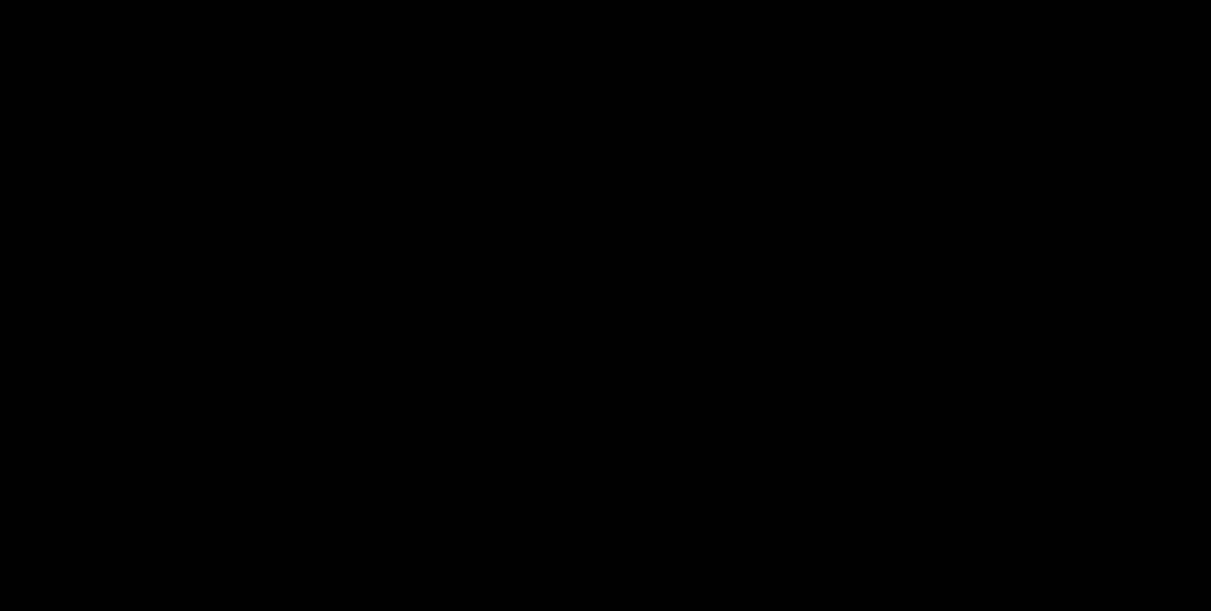

In [ ]:
while it < MAX_ITER:
    freeze(G)
    input_measure_samples_for_D = entropic_sampler.sample(BATCH_SIZE * D_ITERS)
    input_measure_samples_for_T_inv = entropic_sampler.sample(BATCH_SIZE * D_ITERS * T_ITERS)
    input_measure_samples_for_D_inv = entropic_sampler.sample(BATCH_SIZE * D_ITERS)
    # this is a dictionary with k keys, pointing to the samples collected from each measure
    for k in range(num_measures):
        # D and T optimization cycle
        for d_iter in tqdm(range(D_ITERS)):
            it += 1

            # T optimization
            unfreeze(Ts[k]); freeze(Ds[k])
            for t_iter in range(T_ITERS): 
                with torch.no_grad():
                    X = G(Z_sampler.sample(BATCH_SIZE))
                Ts_opt[k].zero_grad()
                T_X = Ts[k](X)
                T_loss = F.mse_loss(X, T_X).mean() - Ds[k](T_X).mean()
                T_loss.backward(); Ts_opt[k].step()
            del T_loss, T_X, X
            gc.collect()

            # D optimization
            with torch.no_grad():
                X = G(Z_sampler.sample(BATCH_SIZE))
            # Y = benchmark.samplers[k].sample(BATCH_SIZE)
            Y = torch.tensor(input_measure_samples_for_D[k][d_iter * BATCH_SIZE : (d_iter + 1) * BATCH_SIZE]).float()
            
            unfreeze(Ds[k]); freeze(Ts[k])
            T_X = Ts[k](X).detach()
            Ds_opt[k].zero_grad()
            D_loss = Ds[k](T_X).mean() - Ds[k](Y).mean()
            D_loss.backward(); Ds_opt[k].step()
            del D_loss, Y, X, T_X
            gc.collect()
            torch.cuda.empty_cache()
            
            # T inv optimization
            unfreeze(Ts_inv[k]); freeze(Ds_inv[k])
            for t_iter in range(T_ITERS): 
                Y = torch.tensor(input_measure_samples_for_T_inv[k][d_iter * T_ITERS * BATCH_SIZE + t_iter * BATCH_SIZE : d_iter * T_ITERS * BATCH_SIZE + (t_iter + 1) * BATCH_SIZE]).float()
                Ts_inv_opt[k].zero_grad()
                T_inv_Y = Ts_inv[k](Y)
                T_inv_loss = F.mse_loss(Y, T_inv_Y).mean() - Ds_inv[k](T_inv_Y).mean()
                T_inv_loss.backward(); Ts_inv_opt[k].step()
            del T_inv_loss, T_inv_Y, Y
            gc.collect()
            # torch.cuda.empty_cache()

            # D inv optimization
            Y = torch.tensor(input_measure_samples_for_D_inv[k][d_iter * BATCH_SIZE : (d_iter + 1) * BATCH_SIZE]).float()
            with torch.no_grad():
                X = G(Z_sampler.sample(BATCH_SIZE))
            
            unfreeze(Ds_inv[k]); freeze(Ts_inv[k])
            T_inv_Y = Ts_inv[k](Y).detach()
            Ds_inv_opt[k].zero_grad()
            D_inv_loss = Ds_inv[k](T_inv_Y).mean() - Ds_inv[k](X).mean()
            D_inv_loss.backward(); Ds_inv_opt[k].step()
            del D_inv_loss, Y, X, T_inv_Y
            gc.collect()
            torch.cuda.empty_cache()

        
    # G optimization
    if G_ITERS > 0:
        for k in range(num_measures):
            freeze(Ts[k])
        G_old = deepcopy(G); freeze(G_old)
        unfreeze(G)
        for g_iter in range(G_ITERS):
            it += 1
            Z = Z_sampler.sample(BATCH_SIZE)
            with torch.no_grad():
                G_old_Z = G_old(Z)
                T_G_old_Z = torch.zeros_like(G_old(Z))
            G_old_Z.requires_grad_(True)
            for k in range(num_measures):
                T_G_old_Z += ALPHAS[k] * Ts[k](G_old_Z)

            G_opt.zero_grad()
            G_loss = .5 * F.mse_loss(G(Z), T_G_old_Z)
            G_loss.backward(); G_opt.step() 

            G_loss_history.append(G_loss.item())

        save_path = f"{save_pathname}/trained_models_iter_{it}.pth"
        # os.makedirs(save_path, exist_ok=True)
        models_to_save = {
            "G": G.state_dict(),
            "Ts": {k: Ts[k].state_dict() for k in range(num_measures)},
            "Ds": {k: Ds[k].state_dict() for k in range(num_measures)},
            # Save the inverse transforms if needed
            "Ts_inv": {k: Ts_inv[k].state_dict() for k in range(num_measures)},
            "Ds_inv": {k: Ds_inv[k].state_dict() for k in range(num_measures)},
        }

        # Save the dictionary
        torch.save(models_to_save, save_path)
        print(f"Models saved to {save_path}")

            # Log G_loss_history to a local file
        with open("G_loss_history.log", "a") as f:
            f.write(f"Iteration {it}, G_loss: {G_loss.item()}\n")

        del G_old, G_loss, T_G_old_Z, Z
        gc.collect()

        # Save the generated samples from the G-mapping at each iteration
        accepted_G_samples = G(Z_sampler.sample(num_samples)).cuda().detach().numpy() #.cpu()
        G_sample_save(G_samples_dict, accepted_G_samples, it, save_pathname = save_pathname)

        # Compute the V-value (i.e.,\@ the weighted sum of the Wasserstein distances between the input measures and the generated samples)
        # Notice that when iter = None, this returns the true V_value given by the ground-truth barycenter;
        V_value_compute(V_values_dict, accepted_G_samples, input_measure_samples, iter = it, save_pathname = save_pathname)

        # Compute the Wasserstein distance between the generated samples from the G-mapping
        # and the barycenter samples at each iteration;
        W2_to_true_bary_compute(W2_to_true_bary_dict, accepted_G_samples, source_measure_samples, it, save_pathname = save_pathname)

        # Plot the generated samples from the G-mapping at each iteration
        plot_2d_compare_with_source_kde(source_measure_samples[:visualize_num_samples], accepted_G_samples[:visualize_num_samples], it, plot_dirc = plot_dirc, scatter = False)
